In [1]:
import os
from PIL import Image

def convert_tif_to_jpg(input_dir, output_dir):
    # Create the output directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Iterate through all files in the input directory
    for filename in os.listdir(input_dir):
        if filename.lower().endswith('.tif') or filename.lower().endswith('.tiff'):
            # Open the TIF image
            tif_path = os.path.join(input_dir, filename)
            with Image.open(tif_path) as img:
                # Create the output JPG filename
                jpg_filename = os.path.splitext(filename)[0] + '.jpg'
                jpg_path = os.path.join(output_dir, jpg_filename)
                
                # Convert and save as JPG
                img.convert('RGB').save(jpg_path, 'JPEG')
                print(f"Converted {filename} to {jpg_filename}")

# Example usage:
input_directory = '/home/nadjaflechner/Palsa_data/generated_datasets/Verified_GTs/rgb'
output_directory = '/home/nadjaflechner/Palsa_data/generated_datasets/Verified_GTs/jpg'
convert_tif_to_jpg(input_directory, output_directory)


Converted 765_74_2500_2016_negcrop_47.tif to 765_74_2500_2016_negcrop_47.jpg
Converted 746_57_5025_2015_crop_93.tif to 746_57_5025_2015_crop_93.jpg
Converted 760_74_5025_2018_negcrop_4.tif to 760_74_5025_2018_negcrop_4.jpg
Converted 765_74_2500_2016_negcrop_43.tif to 765_74_2500_2016_negcrop_43.jpg
Converted 765_74_2525_2016_negcrop_7.tif to 765_74_2525_2016_negcrop_7.jpg
Converted 764_75_2500_2015_crop_78.tif to 764_75_2500_2015_crop_78.jpg
Converted 760_74_5000_2018_negcrop_31.tif to 760_74_5000_2018_negcrop_31.jpg
Converted 746_57_2500_2015_crop_114.tif to 746_57_2500_2015_crop_114.jpg
Converted 733_52_0025_2015_negcrop_10.tif to 733_52_0025_2015_negcrop_10.jpg
Converted 765_74_2500_2016_negcrop_30.tif to 765_74_2500_2016_negcrop_30.jpg
Converted 753_67_2550_2014_crop_98.tif to 753_67_2550_2014_crop_98.jpg
Converted 733_52_0025_2015_negcrop_12.tif to 733_52_0025_2015_negcrop_12.jpg
Converted 760_74_5025_2018_crop_48.tif to 760_74_5025_2018_crop_48.jpg
Converted 757_69_5050_2014_negc

In [8]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import wandb
import rasterio

# model_name = "nvidia/segformer-b5-finetuned-ade-640-640"
model_name = "sawthiha/segformer-b0-finetuned-deprem-satellite"


# Initialize wandb API
api = wandb.Api()

# Specify the artifact path
artifact_path = 'nadjaflechner/Finetune_segformer_sweep/finetuned_segformer:v78'

# Download the artifact
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

# Load the model
device = torch.device("cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    model_name,
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Load the state dict
state_dict = torch.load(f"{artifact_dir}/best_model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Initialize the image processor
image_processor = SegformerImageProcessor(
    image_mean=[74.90, 85.26, 80.06],
    image_std=[15.05, 13.88, 12.01],
    do_reduce_labels=False
)

wandb:   1 of 1 files downloaded.  


[[0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
[[[ 41 170  44]
  [ 40 169  43]
  [ 34 163  36]
  ...
  [ 29  37  32]
  [ 27  35  30]
  [ 35  43  38]]

 [[ 46 175  49]
  [ 37 166  40]
  [ 34 163  37]
  ...
  [ 30  38  33]
  [ 27  35  30]
  [ 33  41  36]]

 [[ 37 166  40]
  [ 30 159  33]
  [ 35 164  37]
  ...
  [ 32  40  35]
  [ 30  38  33]
  [ 36  44  39]]

 ...

 [[ 51  58  49]
  [ 55  62  53]
  [ 56  63  55]
  ...
  [ 44 175  49]
  [ 37 168  42]
  [ 28 159  33]]

 [[ 57  64  55]
  [ 58  65  56]
  [ 58  65  56]
  ...
  [ 48 179  53]
  [ 40 171  45]
  [ 32 163  37]]

 [[ 62  69  60]
  [ 58  65  56]
  [ 57  64  55]
  ...
  [ 47 178  52]
  [ 40 171  45]
  [ 36 167  41]]]


ValueError: operands could not be broadcast together with shapes (400,400,3) (200,200,3) 

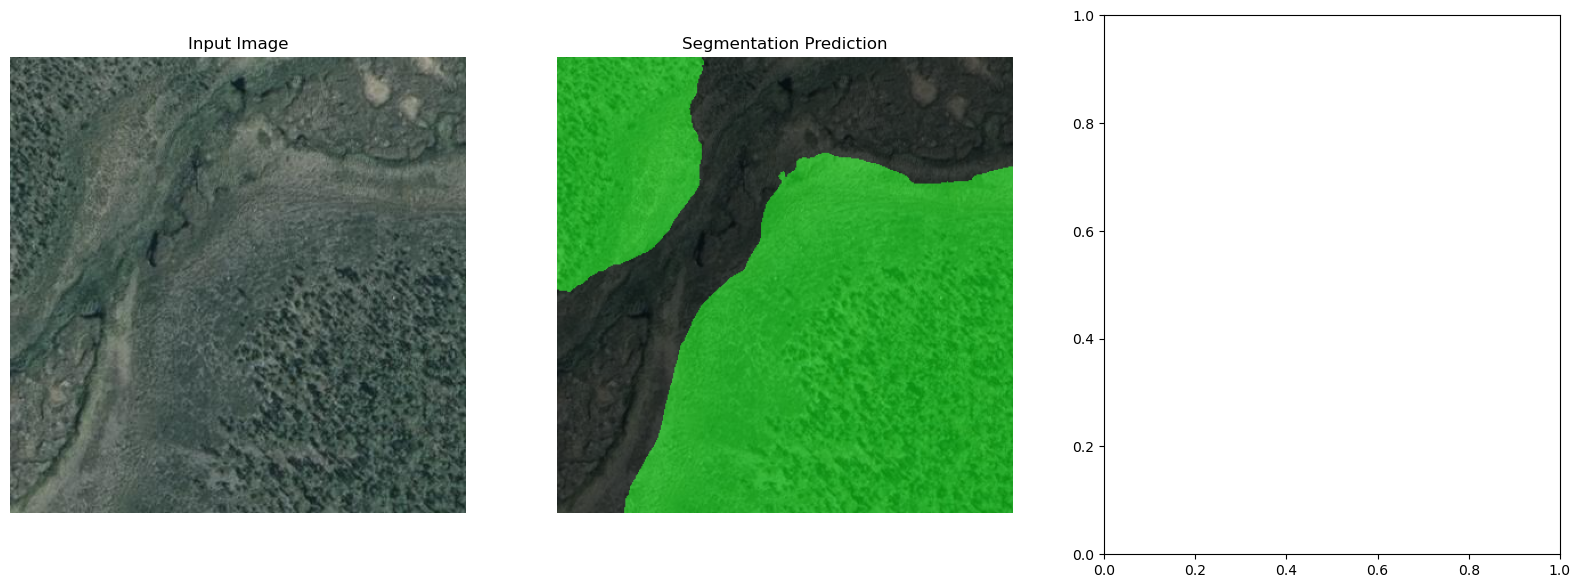

In [10]:

def plot_segmentation(filename):
    # Load and process the image
    image = Image.open(f"/home/nadjaflechner/Palsa_data/generated_datasets/Verified_GTs/jpg/{filename}.jpg")
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    # Process the output
    logits = outputs.logits.cpu()
    predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[image.size[::-1]])[0]
    predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()
    print(predicted_segmentation_map)
    # Create color segmentation
    color_seg = np.zeros((predicted_segmentation_map.shape[0],
                        predicted_segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3

    color = np.array([4, 250, 7])
    color_seg[predicted_segmentation_map == 0, :] = color
    # Convert to BGR
    color_seg = color_seg[..., ::-1]

    # Overlay segmentation on image
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)
    print(img)

    # Plot
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 7))

    # Input image
    ax1.imshow(image)
    ax1.set_title("Input Image")
    ax1.axis('off')

    # Segmentation prediction
    ax2.imshow(img)
    ax2.set_title("Segmentation Prediction")
    ax2.axis('off')

    # Ground truth
    GT = rasterio.open(f"/home/nadjaflechner/Palsa_data/generated_datasets/Verified_GTs/groundtruth_mask/{filename}.tif").read()
    GT = np.squeeze(GT)  # Remove single-dimensional entries
    GT_overlay = np.array(image) * 0.5 + np.expand_dims(GT, axis=2) * np.array([4, 250, 7]) * 0.5
    GT_overlay = GT_overlay.astype(np.uint8)
    ax3.imshow(GT_overlay)
    ax3.set_title("Ground Truth")
    ax3.axis('off')

    plt.tight_layout()
    plt.show()

# Example usage
filenames = ['753_67_2550_2014_crop_51','753_67_2550_2014_crop_61','753_67_2550_2014_crop_62', '760_74_5025_2018_crop_48']
plot_segmentation(filenames[1])

In [6]:
img

NameError: name 'img' is not defined

# Original claude suggestion:

In [ ]:
import torch
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import wandb

# Initialize wandb API
api = wandb.Api()

# Specify the artifact path
artifact_path = 'nadjaflechner/Finetune_segformer_sweep/finetuned_segformer:v44'

# Download the artifact
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegformerForSemanticSegmentation.from_pretrained(
    "nvidia/segformer-b5-finetuned-ade-640-640",
    num_labels=2,
    ignore_mismatched_sizes=True
).to(device)

# Load the state dict
state_dict = torch.load(f"{artifact_dir}/model.pth", map_location=device)
model.load_state_dict(state_dict)
model.eval()

# Initialize the image processor
image_processor = SegformerImageProcessor(
    image_mean=[74.90, 85.26, 80.06],
    image_std=[15.05, 13.88, 12.01],
    do_reduce_labels=False
)

def plot_segmentation(image_path):
    # Load and process the image
    image = Image.open(image_path)
    pixel_values = image_processor(image, return_tensors="pt").pixel_values.to(device)

    # Generate prediction
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)

    # Process the output
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False
    )
    predicted_segmentation_map = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy()

    # Create color segmentation
    color_seg = np.zeros((predicted_segmentation_map.shape[0],
                          predicted_segmentation_map.shape[1], 3), dtype=np.uint8)
    
    color = np.array([4, 250, 7])  # Green color for the segmentation
    color_seg[predicted_segmentation_map == 1] = color  # Assuming 1 is the target class
    
    # Overlay segmentation on image
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    # Plot
    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.title("Segmentation Result")
    plt.axis('off')
    plt.show()

# Example usage
image_path = "path/to/your/image.jpg"
plot_segmentation(image_path)